In [1]:
%cd ..

/home/sazerlife/projects/introductions-tasks/binary_sex_сlassifier


In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import soundfile as sf
import pandas as pd
import numpy as np
from librosa import get_duration
from tqdm import tqdm
import warnings
import torchaudio

warnings.filterwarnings("ignore")
tqdm.pandas()

DATA_FOLDER = Path("data/external/LibriTTS/")

/home/sazerlife/.conda/envs/torch=3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(DATA_FOLDER / "speakers.tsv", sep="\t")

In [4]:
full_df = list()
for reader, gender, subset, name in df.values:
    reader_dir: Path = DATA_FOLDER / subset/ str(reader)
    for wav_path in list(reader_dir.rglob("*.wav")):
        sample = (reader, gender, subset, name, wav_path)
        full_df.append(sample)
full_df = pd.DataFrame(full_df, columns=['READER', 'GENDER', 'SUBSET', 'NAME', "WAV_PATH"])

In [5]:
train_df = full_df.loc[full_df['SUBSET'] == "train-clean-100"]
val_df = full_df.loc[full_df['SUBSET'] == "dev-clean"]

## Оценка сбалансированности датасета

### Баланс классов

Датасет довольно хорошо сбалансирован с точки зрения количества примеров разных классов

In [6]:
print(train_df['GENDER'].value_counts())
print(val_df['GENDER'].value_counts())

F    17629
M    15607
Name: GENDER, dtype: int64
F    2976
M    2760
Name: GENDER, dtype: int64


### Баланс спикеров

С точки зрения баланса спикеров здесь всё несколько хуже. В обучающей выборке на ~25-30% спикеров приходится меньше 100 записей при медиане - 150.


В целом, в рамках поставленной задачи нет необходимости с этим что-то делать, но на будущее развитие для лучшей генерализации модели я бы предложил попробовать провести такие эксперименты:
* назначать каждой записи вес, в зависимости от того, кто эту запись говорит
* делать случайное смещение pitch-а (небольшое, ~лад/полулад вверх и вних, чтобы это не повлияло на восприятие пола говорящего) в процессе обучения
* делать случайное увеличение/уменьшение темпа записи

Text(0, 0.5, 'Кол-во записей')

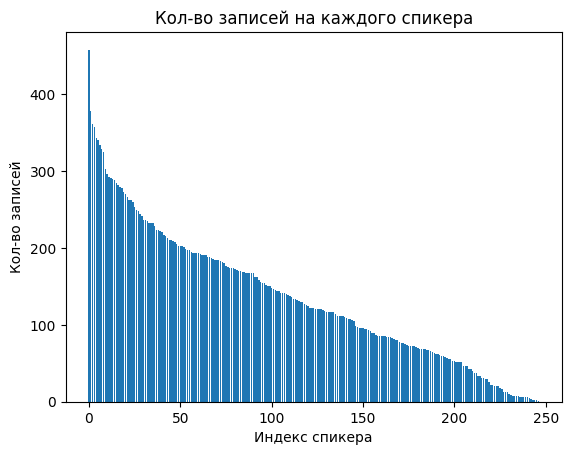

In [7]:
readers_examples_count = train_df['READER'].value_counts().values

_, ax = plt.subplots()
ax.bar([i for i in range(len(readers_examples_count))], readers_examples_count)
ax.set_title("Кол-во записей на каждого спикера")
ax.set_xlabel("Индекс спикера")
ax.set_ylabel("Кол-во записей")

В валидационной выборке распределение примерно то же

Text(0, 0.5, 'Кол-во записей')

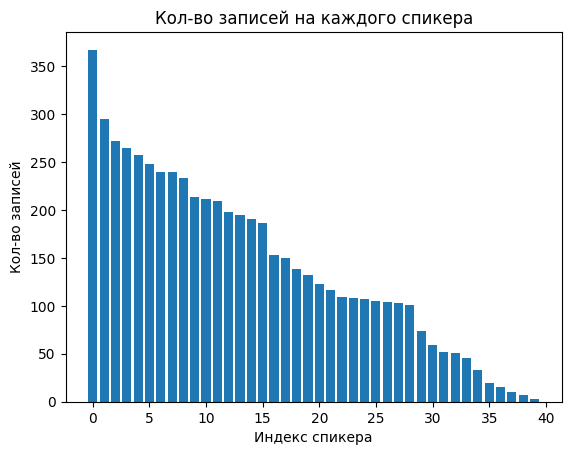

In [8]:
readers_examples_count = val_df['READER'].value_counts().values

_, ax = plt.subplots()
ax.bar([i for i in range(len(readers_examples_count))], readers_examples_count)
ax.set_title("Кол-во записей на каждого спикера")
ax.set_xlabel("Индекс спикера")
ax.set_ylabel("Кол-во записей")

## Изучение аудиоданных

### Распределение по длительности аудиоданных

Медиана длительности записей находится чуть ниже 5 секунд. Это значение будет учтено при стандартизации данных.

In [9]:
train_df['DURATIONS'] = train_df['WAV_PATH'].progress_apply(lambda wav_path: get_duration(filename=wav_path))
val_df['DURATIONS'] = val_df['WAV_PATH'].progress_apply(lambda wav_path: get_duration(filename=wav_path))

100%|██████████| 5736/5736 [00:00<00:00, 27780.31it/s]


Text(0, 0.5, 'Секунды')

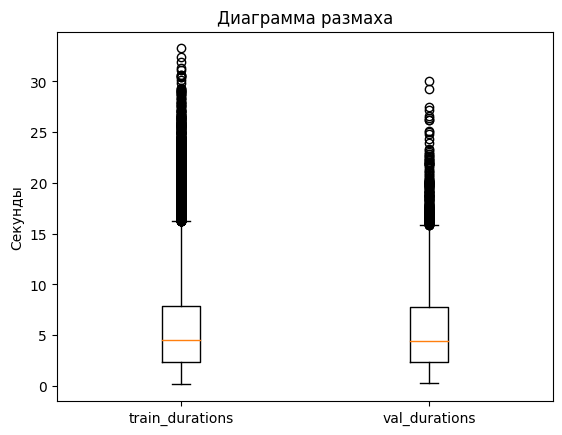

In [10]:
_, ax = plt.subplots()
ax.boxplot([train_df['DURATIONS'], val_df['DURATIONS']])
ax.set_xticklabels(["train_durations", "val_durations"])
ax.set_title("Диаграмма размаха")
ax.set_ylabel("Секунды")

Послушаем несколько примеров из датасета и убедимся, что в них нет какой-нибудь глупой ошибки, из-за которой запись и метки могли бы не соответствовать друг другу

In [11]:
from IPython.display import Audio
from random import choice

In [29]:
wav_path, gender = choice(train_df[["WAV_PATH", "GENDER"]].values)
print(gender)
Audio(wav_path)

F


Как мы знаем, в природе обычно мужской голос звучит ниже, чем женский, а значит у мужского голоса значение фундаментальной частоты должно быть ниже. 


Вчислив pitch на нескольких записях женских и мужских голосов, я убедился, что pitch, вычисленный функцией `detect_pitch_frequency` действительно отличается для разных меток

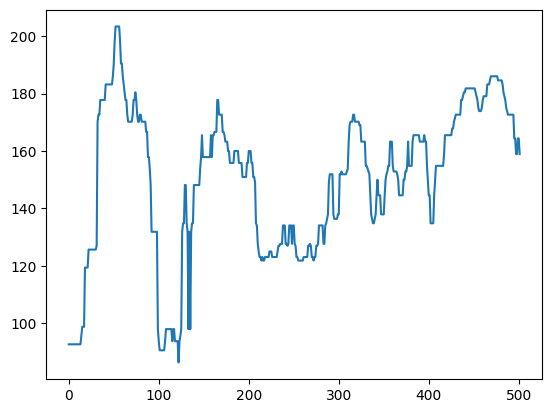

In [30]:
audio, sr = torchaudio.load(wav_path, normalize=True)
audio = audio / audio.abs().max()
pitch = torchaudio.functional.detect_pitch_frequency(audio, sr, freq_high=700, freq_low=50, win_length=100)
plt.plot(pitch[0])

In [37]:
wav_path, gender = choice(val_df[["WAV_PATH", "GENDER"]].values)
print(gender)
Audio(wav_path)

M


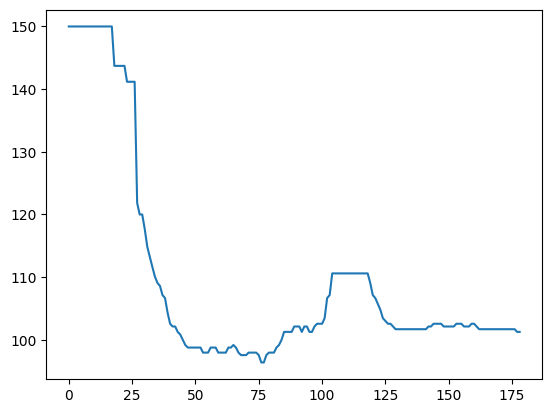

In [40]:
audio, sr = torchaudio.load(wav_path, normalize=True)
audio = audio / audio.abs().max()
pitch = torchaudio.functional.detect_pitch_frequency(audio, sr, freq_high=700, freq_low=50, win_length=100)
plt.plot(pitch[0])

In [41]:
import torchaudio.transforms as T

transform = T.Spectrogram(
    n_fft=1024,
    win_length=1024,
    hop_length=512,
    pad=0,
    power=2.0,
    normalized=False,
    center=True,
    pad_mode="reflect",
    onesided=True,
)

In [42]:
spec = transform(audio)

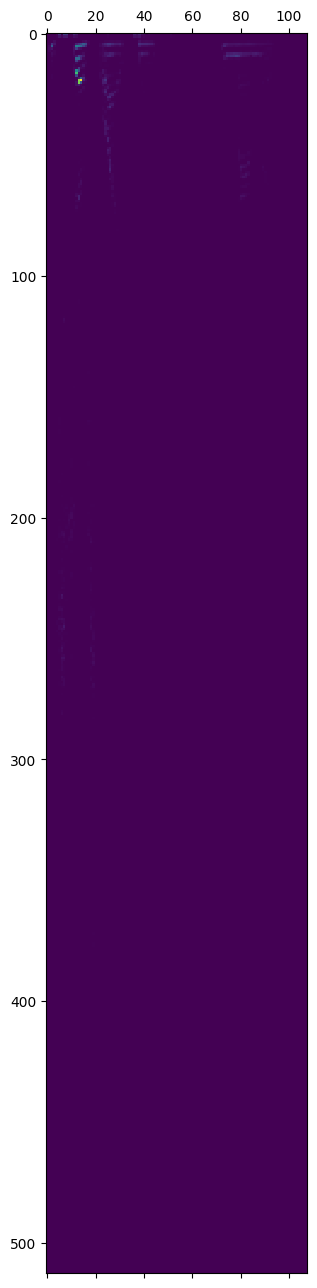

In [44]:
plt.matshow(spec[0])

In [43]:
spec.shape

torch.Size([1, 513, 108])